In [1]:
from google.colab import drive, auth
import sys
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import librosa
import matplotlib.pyplot as plt
import csv
from IPython.display import Audio

#sklearn libraries
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#tensorflow for modles
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Conv2D, MaxPooling2D, Flatten, concatenate, Reshape, BatchNormalization
import tensorflow_hub as hub
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback,EarlyStopping
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

#mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#declare sampling rate
sampling_rate = 16000
#get the audio path of all the audios
audio_path = '/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/data/train/librosa_loaded/'

In [3]:
#Read the data and get the shapes of the dataframe
bird_df = pd.read_csv('/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/notebooks/RG/3_species/train_val.csv')
bird_df.shape

#Gather the training data from the main dataset
bird_train_df = bird_df[bird_df['data'] == 'train']
print("train data:",bird_train_df.shape)

#Gather the separate validation set from the csv
bird_val_df =  bird_df[bird_df['data'] == 'val']
print("validation data:",bird_val_df.shape)

train data: (657, 9)
validation data: (283, 9)


Functions below
1. Load the audio file
2. Segment the audio into 5 secs with 2.5 secs overlap
3. Resample audio frames that are less than 8 seconds while getting the audio frames
4. Extract MFCC from every segment of audio

In [4]:
#Function to load the audio
def load_audio(file_name):
    audio = np.load(audio_path + file_name)
    return audio

In [9]:
#chunk the audio into 5 sec frame with no overlaps
def frame_audio(
      audio_array: np.ndarray,
      window_size_s: float = 5.0,
      hop_size_s: float = 2.5,
      sample_rate = sampling_rate,
      ) -> np.ndarray:

    """Helper function for framing audio for inference."""
    """ using tf.signal """
    if window_size_s is None or window_size_s < 0:
        return audio_array[np.newaxis, :]
    frame_length = int(window_size_s * sample_rate)
    hop_length = int(hop_size_s * sample_rate)
    framed_audio = tf.signal.frame(audio_array, frame_length, hop_length, pad_end=False)
    return framed_audio

In [10]:
#extract mfcc from frames
def extract_mfcc_from_frames(framed_audio, class_label, sample_rate=16000, n_mfcc=20):
  mfcc_frames = []
  target_label = []
  for frame in framed_audio:
    frame = np.array(frame)

    #Extract mfcc from the main audio frame
    mfcc = librosa.feature.mfcc(y=frame, sr=sample_rate, n_mfcc=n_mfcc)

    #Transpose the MFCC matrix
    transposed_mfcc = mfcc.T

    #lets get the mfcc
    mfcc_frames.append(transposed_mfcc)

    #append the labels for every frame
    target_label.append(class_label)

  return mfcc_frames,target_label

In [11]:
#extract the final features
def extract_final_features_from_dataframe(df):
    mfccs = []
    target_labels = []
    for index, row in df.iterrows():
        file_name = str(row['filename_npy'])
        class_label = row["primary_label"]
        duration = row['duration_secs_32000']
        if duration < 10:
            # Load the audio using the load_audio function
            audio = load_audio(file_name)
            # Calculate the time stretch factor to make the audio 10 seconds long
            time_stretch_factor = 10 / duration
            # Resample the audio to make it 10 seconds long
            audio_stretched = librosa.resample(audio, orig_sr=sampling_rate, target_sr=int(sampling_rate * time_stretch_factor))
            framed_audio = frame_audio(audio_stretched)  # Frame the time-stretched audio into 5-second segments
        else:
            # For audios with duration >= 10 seconds, proceed as before
            audio = load_audio(file_name)  # Load the audio using the load_audio function
            framed_audio = frame_audio(audio)  # Frame the audio into 8-second segments

        mfcc_frames, target_label = extract_mfcc_from_frames(framed_audio, class_label, sample_rate=sampling_rate)  # Extract MFCC features for each frame
        mfccs.extend(mfcc_frames)
        target_labels.extend(target_label)
    return mfccs, target_labels

In [12]:
#encode the target variable
def encode_labels(y_train, y_val):
    # Perform one-hot encoding on y_train
    le = LabelEncoder()
    encoded_y_train = to_categorical(le.fit_transform(y_train))

    # Perform one-hot encoding on y_val
    le = LabelEncoder()
    encoded_y_val = to_categorical(le.fit_transform(y_val))

    return encoded_y_train, encoded_y_val

In [13]:
#create a function to shuffle the data
def shuffle_data(x, y, random_state=1234):
    num_samples = x.shape[0]
    random_indices = np.random.RandomState(random_state).permutation(num_samples)
    x_shuffled = x[random_indices]
    y_shuffled = y[random_indices]
    return x_shuffled, y_shuffled

In [14]:
#scale data
def scale_data(data):
    # Reshape the data to 2D array
    num_samples, num_time_steps, num_features = data.shape
    data_reshaped = data.reshape(num_samples, num_features * num_time_steps)

    # Create the MinMaxScaler object and fit it to the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data_reshaped)

    # Reshape the scaled data back to its original shape
    data_scaled = data_scaled.reshape(num_samples, num_time_steps, num_features)

    return data_scaled

In [15]:
#extract the mfcc embeddings from the model
mfcc_embeddings, labels = extract_final_features_from_dataframe(bird_train_df)

In [16]:
#display a sample embedding from the training dataset
mfcc_embeddings[:1]

[array([[-640.8579   ,   64.677185 ,  -62.988552 , ...,   -6.7448916,
           -1.0803337,   -1.5052841],
        [-367.0238   ,   61.163193 ,  -64.072556 , ...,   -6.0492578,
          -10.800379 ,   -6.3168383],
        [-292.5032   ,   58.88469  ,  -67.405975 , ...,   -2.8861198,
           -7.559266 ,   -2.872631 ],
        ...,
        [-276.97238  ,   53.687866 ,  -43.175415 , ...,   -7.3569508,
           -5.576524 ,    1.9049327],
        [-269.13995  ,   34.2004   ,  -37.430283 , ...,    3.6669822,
           -1.3040459,   -2.1778526],
        [-294.32895  ,   27.14126  ,  -45.10728  , ...,   10.434868 ,
           -0.9374119,   -4.9370155]], dtype=float32)]

In [17]:
#verify the shapes
x_train = np.array(mfcc_embeddings)
y_train = np.array(labels)
print(x_train.shape)
print(y_train.shape)

(7997, 157, 20)
(7997,)


In [18]:
#extract the embeddings
val_embeddings, val_labels = extract_final_features_from_dataframe(bird_val_df)

In [19]:
#display a sample embedding from the validation dataset
val_embeddings[:1]

[array([[-340.6138   ,  127.00826  ,   44.271774 , ...,   10.514736 ,
           -0.6833378,   11.0607815],
        [-283.6167   ,  124.63982  ,   38.063232 , ...,   11.196489 ,
            0.567252 ,    6.3750343],
        [-275.97565  ,  124.30683  ,   34.929054 , ...,    5.1549063,
            2.2961612,    3.1506374],
        ...,
        [-255.79277  ,  143.95294  ,   43.216595 , ...,    2.4150612,
            1.5392418,   -1.5801059],
        [-256.25858  ,  140.16705  ,   39.414555 , ...,    4.858892 ,
            5.822331 ,    3.4978468],
        [-267.41135  ,  131.66406  ,   34.269558 , ...,    3.8172016,
            1.4814109,    1.075378 ]], dtype=float32)]

In [20]:
#verify the val data shapes
x_val = np.array(val_embeddings)
y_val = np.array(val_labels)
print(x_val.shape)
print(y_val.shape)

(3178, 157, 20)
(3178,)


In [21]:
#call the function to encode y
y_train_encoded, y_val_encoded = encode_labels(y_train, y_val)
#verify the shape
print(y_train_encoded.shape)
print(y_val_encoded.shape)

(7997, 3)
(3178, 3)


In [28]:
#scale the extracted embeddings
x_train_scaled = scale_data(x_train)
x_val_scaled = scale_data(x_val)
print(x_train_scaled[:1])
print(x_val_scaled[:1])

[[[0.3362782  0.63971686 0.32631367 ... 0.37747377 0.51355165 0.5018626 ]
  [0.58046937 0.6189263  0.38298434 ... 0.51353556 0.4062525  0.35259184]
  [0.6561823  0.63951075 0.45447195 ... 0.5273852  0.51709694 0.46967593]
  ...
  [0.68143976 0.64805084 0.4910186  ... 0.37031484 0.5724295  0.49373794]
  [0.6882441  0.6093024  0.49213013 ... 0.5001638  0.55882967 0.4261627 ]
  [0.6732929  0.5790205  0.45699272 ... 0.5745449  0.47061977 0.3183377 ]]]
[[[0.6569526  0.84288013 0.7965894  ... 0.6587498  0.48880005 0.59466356]
  [0.6823303  0.8138336  0.7948566  ... 0.64670825 0.4989489  0.5700629 ]
  [0.67542744 0.78347605 0.7719439  ... 0.55752444 0.5587748  0.4757049 ]
  ...
  [0.71165264 0.8393796  0.831839   ... 0.517175   0.53961074 0.35174182]
  [0.7122661  0.84823436 0.7618222  ... 0.4940191  0.66624135 0.47463515]
  [0.71977186 0.83000076 0.70910895 ... 0.4851028  0.6010099  0.36560658]]]


In [29]:
#shuffle both train and validation sets
x_shuffled_train, y_shuffled_train = shuffle_data(x_train_scaled, y_train_encoded)
x_shuffled_val, y_shuffled_val = shuffle_data(x_val_scaled, y_val_encoded)

print(x_shuffled_train.shape)
print(y_shuffled_train.shape)

print(x_shuffled_val.shape)
print(y_shuffled_val.shape)

(7997, 157, 20)
(7997, 3)
(3178, 157, 20)
(3178, 3)


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def train_sequential_model(x_train, y_train, x_val, y_val, learning_rate=0.002, batch_size=32, n_classes=3, epochs=100):
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  #Create the sequential model
  model = keras.Sequential()

  #design the layers of the model
  model.add(Flatten(input_shape=(x_train.shape[1], x_train.shape[2])))  # Flatten the 2D MFCC frames


  #This layer constructs the linear set of parameters for each input feature
  model.add(keras.layers.Dense(
      units=512,
      activation="relu"
  ))
  #add batch normalization
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  #This layer constructs the linear set of parameters for each input feature
  model.add(keras.layers.Dense(
      units=256,
      activation="relu"
  ))
  #add batch normalization
  model.add(BatchNormalization())
  model.add(Dropout(0.2))


   #This layer constructs the linear set of parameters for each input feature
  model.add(keras.layers.Dense(
      units=128,
      activation="relu"
  ))

  #add batch normalization
  model.add(BatchNormalization())
  #model.add(Dropout(0.2))

  #This layer constructs the linear set of parameters for each input feature
  model.add(keras.layers.Dense(
      units=64,
      activation="relu"
  ))
  model.add(BatchNormalization())
  model.add(Dense(n_classes, activation='softmax'))

  #Use the Adam optimizer as usual.
  #optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  #Use the SGD optimizer as usual.
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  #compile the model
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  model.summary()

  earlystop = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')

  #Train the model
  history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                        batch_size=batch_size, callbacks=[earlystop], epochs=epochs)

  return history

In [25]:
#call the model
history = train_sequential_model(x_shuffled_train, y_shuffled_train, x_shuffled_val, y_shuffled_val, learning_rate=0.002, batch_size=32, n_classes=3, epochs=100)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3140)              0         
                                                                 
 dense (Dense)               (None, 512)               1608192   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

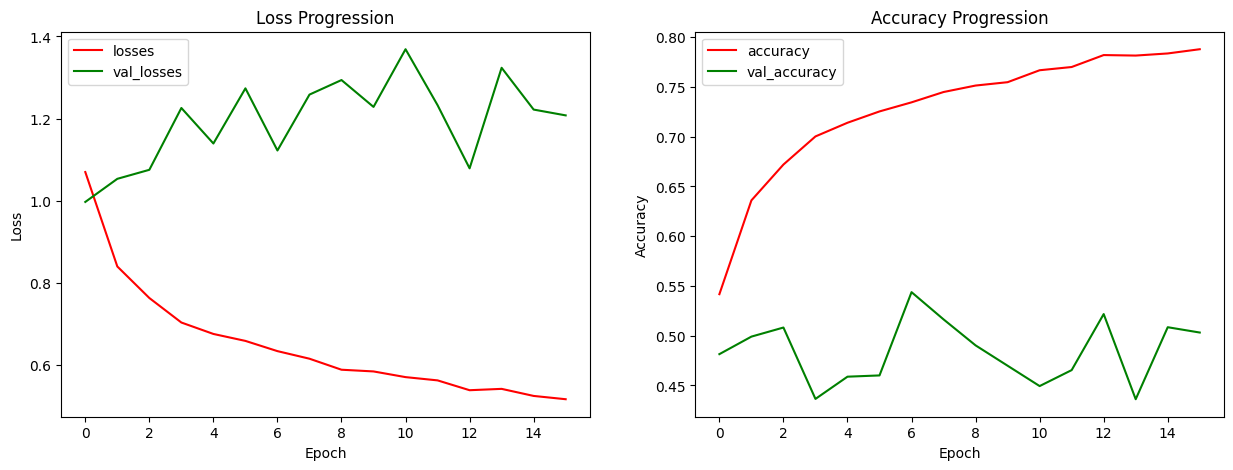

In [26]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    # Plot the training and validation accuracy and losses
    num_epochs = len(history.history['loss'])
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    axes[0].plot(range(num_epochs), history.history['loss'], color='red', label='losses')
    axes[0].plot(range(num_epochs), history.history['val_loss'], color='green', label='val_losses')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss Progression')
    axes[0].legend()

    axes[1].plot(range(num_epochs), history.history['accuracy'], color='red', label='accuracy')
    axes[1].plot(range(num_epochs), history.history['val_accuracy'], color='green', label='val_accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy Progression')
    axes[1].legend()
    plt.show()

#call the plot function
plot_accuracy(history)

In [31]:
# The result of model.predict has an extra dimension, so we flatten to get a
# vector of predictions.
test_pred_train = np.argmax(history.model.predict(x_shuffled_train), axis=-1)
test_pred = np.argmax(history.model.predict(x_shuffled_val), axis=-1)
print(test_pred_train)
print(test_pred)

100/100 [==============================] - 1s 10ms/step
[0 2 0 ... 2 1 2]
[2 2 2 ... 2 2 0]


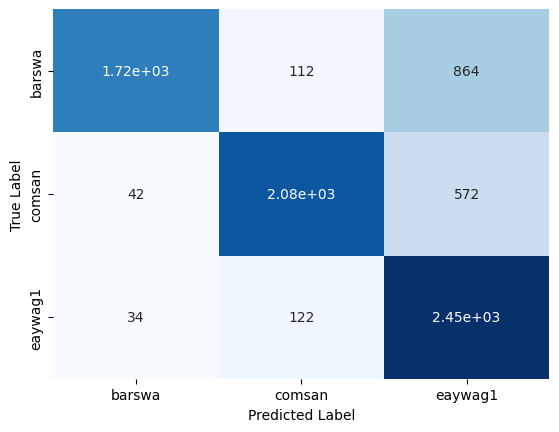

              precision    recall  f1-score   support

           0      0.958     0.638     0.766      2698
           1      0.899     0.772     0.831      2696
           2      0.630     0.940     0.755      2603

    accuracy                          0.782      7997
   macro avg      0.829     0.784     0.784      7997
weighted avg      0.831     0.782     0.784      7997



In [32]:
#plot the  confusion matrix on the train dataset
class_label = ['barswa',  'comsan',  'eaywag1']

# Create a confusion matrix as a 2D array.
from sklearn import metrics

y_train_1d = np.argmax(y_shuffled_train, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_train_1d, test_pred_train)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=class_label, yticklabels=class_label, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

#Print the precision, recall and F1-score using metrics from sklearn
print(metrics.classification_report(y_train_1d, test_pred_train, digits=3, zero_division='warn'))

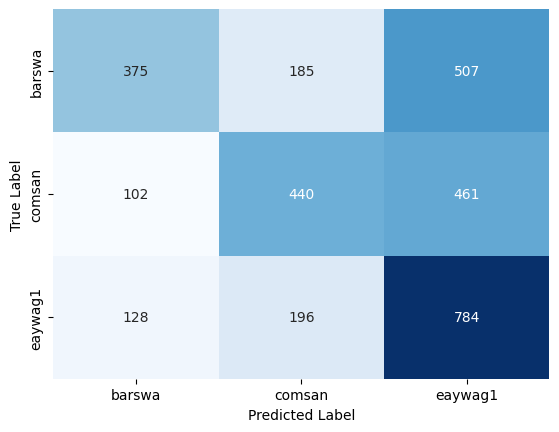

              precision    recall  f1-score   support

           0      0.620     0.351     0.449      1067
           1      0.536     0.439     0.482      1003
           2      0.447     0.708     0.548      1108

    accuracy                          0.503      3178
   macro avg      0.534     0.499     0.493      3178
weighted avg      0.533     0.503     0.494      3178



In [33]:
#plot the confusion matrix on the test dataset
class_label = ['barswa',  'comsan',  'eaywag1']

# Create a confusion matrix as a 2D array.
from sklearn import metrics

y_val_1d = np.argmax(y_shuffled_val, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_val_1d, test_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=class_label, yticklabels=class_label, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

#Print the precision, recall and F1-score using metrics from sklearn
print(metrics.classification_report(y_val_1d, test_pred, digits=3, zero_division='warn'))

Conclusion: The model's is performing just better than random guessing.
Class 0: The precision (0.620) is relatively higher than recall (0.351), indicating that when the model predicts this class, it is correct 62% of the time. However, it misses many instances of this class, as shown by the low recall.

Class 1: The precision (0.536) and recall (0.439) are both moderate. The model is somewhat better at identifying this class than class 0

Class 2: The precision (0.447) is lower compared to the other classes, indicating that when the model predicts this class, it is correct 44.7% of the time.